In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU detectada. Revisa drivers y CUDA.")
else:
    print("✅ GPU detectada:", gpus)

2025-04-06 16:48:49.736884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-06 16:48:50.914643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


✅ GPU detectada: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-06 16:48:54.280844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 16:48:54.427692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 16:48:54.427853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
def resumen(model=None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)
    
  
vgg16=None

# Carga del modelo

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
    
resumen(conv_base)

2025-04-06 16:48:58.846135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 16:48:58.846333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 16:48:58.846442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_1          [(None, 224, 224, 3)]    [(None, 224, 224, 3)]             0
1    block1_conv1     (None, 224, 224, 3)      (None, 224, 224, 64)           1792
2    block1_conv2     (None, 224, 224, 64)     (None, 224, 224, 64)          36928
3    block1_pool      (None, 224, 224, 64)     (None, 112, 112, 64)              0
4    block2_conv1     (None, 112, 112, 64)     (None, 112, 112, 128)         73856
5    block2_conv2     (None, 112, 112, 128)    (None, 112, 112, 128)        147584
6    block2_pool      (None, 112, 112, 128)    (None, 56, 56, 128)               0
7    block3_conv1     (None, 56, 56, 128)      (None, 56, 56, 256)          295168
8    block3_conv2     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
9    block3_conv3     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
10   block3_pool      (None, 56, 56, 256)      (None, 28, 28, 256)               0
11  

# Carga de los datos

In [4]:
from medmnist.dataset import BloodMNIST
import numpy as np

In [5]:
train_dataset = BloodMNIST(split='train', download=True)
val_dataset = BloodMNIST(split='val', download=True)
test_dataset = BloodMNIST(split='test', download=True)

Using downloaded and verified file: /home/juancho/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/juancho/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/juancho/.medmnist/bloodmnist.npz


In [ ]:
x_train, y_train = train_dataset.imgs, train_dataset.labels
print(f"Train shape: {x_train.shape}, Labels shape: {y_train.shape}")

# Definicion de funciones de preprocesamiento y feature extraction

In [ ]:
import numpy as np
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=20

def preprocess_images(images):
    from tensorflow.image import resize
    images_resized = np.zeros((images.shape[0], 224, 224, 3), dtype='float32')
    for i in tqdm(range(images.shape[0]), desc='Redimensionando y preprocesando'):
        img_resized = resize(images[i], (224, 224)).numpy()
        img_array = preprocess_input(img_resized)
        images_resized[i] = img_array
    return images_resized

def extract_features_from_array(images, labels, sample_count, batch_size=20):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels_out    = np.zeros(shape=(sample_count))

    generator = datagen.flow(
        x=images,
        y=labels,
        batch_size=batch_size,
        shuffle=True
    )

    i = 0
    for inputs_batch, labels_batch in tqdm(generator, total=np.floor(sample_count / batch_size).astype(int), desc='Extrayendo features'):
        features_batch = conv_base.predict(inputs_batch)
        batch_len = inputs_batch.shape[0]
        features[i:i+batch_len] = features_batch
        labels_out[i:i+batch_len] = labels_batch.flatten()
        i += batch_len
        if i >= sample_count:
            break

    return features, labels_out

# Feature extraction de los datos

In [ ]:
num_samples_train = 2000 # para evitar procesar todo el dataset
train_images = preprocess_images(x_train[:num_samples_train])
train_features, train_labels = extract_features_from_array(train_images, y_train[:num_samples_train], num_samples_train)

Redimensionando y preprocesando:   0%|          | 0/2000 [00:00<?, ?it/s]

Extrayendo features:   0%|          | 0/100 [00:00<?, ?it/s]2025-04-06 17:00:52.228711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-04-06 17:00:53.585953: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-06 17:00:53.586002: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-06 17:00:53.724793: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, 

1/1 [==============================] - 6s 6s/step


Extrayendo features:   1%|          | 1/100 [00:06<09:56,  6.02s/it]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:   2%|▏         | 2/100 [00:06<04:21,  2.67s/it]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:   3%|▎         | 3/100 [00:06<02:38,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


Extrayendo features:   4%|▍         | 4/100 [00:07<01:46,  1.11s/it]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:   5%|▌         | 5/100 [00:07<01:17,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:   6%|▌         | 6/100 [00:07<00:59,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:   7%|▋         | 7/100 [00:07<00:48,  1.91it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:   8%|▊         | 8/100 [00:08<00:41,  2.23it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:   9%|▉         | 9/100 [00:08<00:36,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  10%|█         | 10/100 [00:08<00:32,  2.76it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  11%|█         | 11/100 [00:09<00:30,  2.93it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  12%|█▏        | 12/100 [00:09<00:28,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


Extrayendo features:  13%|█▎        | 13/100 [00:09<00:27,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Extrayendo features:  14%|█▍        | 14/100 [00:09<00:26,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


Extrayendo features:  15%|█▌        | 15/100 [00:10<00:26,  3.25it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  16%|█▌        | 16/100 [00:10<00:25,  3.33it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  17%|█▋        | 17/100 [00:10<00:24,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


Extrayendo features:  18%|█▊        | 18/100 [00:11<00:24,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  19%|█▉        | 19/100 [00:11<00:23,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Extrayendo features:  20%|██        | 20/100 [00:11<00:23,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  21%|██        | 21/100 [00:11<00:23,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  22%|██▏       | 22/100 [00:12<00:22,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  23%|██▎       | 23/100 [00:12<00:22,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  24%|██▍       | 24/100 [00:12<00:21,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  25%|██▌       | 25/100 [00:13<00:21,  3.46it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  26%|██▌       | 26/100 [00:13<00:21,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  27%|██▋       | 27/100 [00:13<00:21,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  28%|██▊       | 28/100 [00:13<00:20,  3.49it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  29%|██▉       | 29/100 [00:14<00:20,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Extrayendo features:  30%|███       | 30/100 [00:14<00:20,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Extrayendo features:  31%|███       | 31/100 [00:14<00:20,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  32%|███▏      | 32/100 [00:15<00:20,  3.35it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  33%|███▎      | 33/100 [00:15<00:19,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


Extrayendo features:  34%|███▍      | 34/100 [00:15<00:19,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


Extrayendo features:  35%|███▌      | 35/100 [00:16<00:19,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  36%|███▌      | 36/100 [00:16<00:18,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  37%|███▋      | 37/100 [00:16<00:18,  3.45it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  38%|███▊      | 38/100 [00:16<00:17,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  39%|███▉      | 39/100 [00:17<00:17,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  40%|████      | 40/100 [00:17<00:17,  3.46it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  41%|████      | 41/100 [00:17<00:16,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  42%|████▏     | 42/100 [00:18<00:16,  3.48it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  43%|████▎     | 43/100 [00:18<00:16,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  44%|████▍     | 44/100 [00:18<00:16,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  45%|████▌     | 45/100 [00:18<00:15,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  46%|████▌     | 46/100 [00:19<00:15,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  47%|████▋     | 47/100 [00:19<00:15,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  48%|████▊     | 48/100 [00:19<00:14,  3.49it/s]

1/1 [==============================] - 0s 18ms/step


Extrayendo features:  49%|████▉     | 49/100 [00:20<00:14,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  50%|█████     | 50/100 [00:20<00:14,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  51%|█████     | 51/100 [00:20<00:14,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  52%|█████▏    | 52/100 [00:20<00:13,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  53%|█████▎    | 53/100 [00:21<00:13,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  54%|█████▍    | 54/100 [00:21<00:13,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  55%|█████▌    | 55/100 [00:21<00:12,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  56%|█████▌    | 56/100 [00:22<00:12,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  57%|█████▋    | 57/100 [00:22<00:12,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  58%|█████▊    | 58/100 [00:22<00:12,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  59%|█████▉    | 59/100 [00:22<00:11,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  60%|██████    | 60/100 [00:23<00:11,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  61%|██████    | 61/100 [00:23<00:11,  3.44it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  62%|██████▏   | 62/100 [00:23<00:10,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  63%|██████▎   | 63/100 [00:24<00:10,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  64%|██████▍   | 64/100 [00:24<00:10,  3.49it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  65%|██████▌   | 65/100 [00:24<00:10,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  66%|██████▌   | 66/100 [00:24<00:09,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  67%|██████▋   | 67/100 [00:25<00:09,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  68%|██████▊   | 68/100 [00:25<00:09,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  69%|██████▉   | 69/100 [00:25<00:08,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  70%|███████   | 70/100 [00:26<00:08,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  71%|███████   | 71/100 [00:26<00:08,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  72%|███████▏  | 72/100 [00:26<00:07,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  73%|███████▎  | 73/100 [00:26<00:07,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  74%|███████▍  | 74/100 [00:27<00:07,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  75%|███████▌  | 75/100 [00:27<00:07,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  76%|███████▌  | 76/100 [00:27<00:06,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  77%|███████▋  | 77/100 [00:28<00:06,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  78%|███████▊  | 78/100 [00:28<00:06,  3.51it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  79%|███████▉  | 79/100 [00:28<00:05,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  80%|████████  | 80/100 [00:28<00:05,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  81%|████████  | 81/100 [00:29<00:05,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  82%|████████▏ | 82/100 [00:29<00:05,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  83%|████████▎ | 83/100 [00:29<00:04,  3.48it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  84%|████████▍ | 84/100 [00:30<00:04,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  85%|████████▌ | 85/100 [00:30<00:04,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  86%|████████▌ | 86/100 [00:30<00:04,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  87%|████████▋ | 87/100 [00:30<00:03,  3.50it/s]

1/1 [==============================] - 0s 18ms/step


Extrayendo features:  88%|████████▊ | 88/100 [00:31<00:03,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  89%|████████▉ | 89/100 [00:31<00:03,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  90%|█████████ | 90/100 [00:31<00:02,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  91%|█████████ | 91/100 [00:32<00:02,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  92%|█████████▏| 92/100 [00:32<00:02,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  93%|█████████▎| 93/100 [00:32<00:02,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  94%|█████████▍| 94/100 [00:32<00:01,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  95%|█████████▌| 95/100 [00:33<00:01,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  96%|█████████▌| 96/100 [00:33<00:01,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  97%|█████████▋| 97/100 [00:33<00:00,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  98%|█████████▊| 98/100 [00:34<00:00,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


Extrayendo features:  99%|█████████▉| 99/100 [00:34<00:00,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  99%|█████████▉| 99/100 [00:34<00:00,  2.85it/s]


In [ ]:
del x_train, y_train # para evitar usar memoria innecesaria
num_samples_test = 1000 # para evitar procesar todo el dataset
x_val, y_val = val_dataset.imgs, val_dataset.labels
x_test, y_test = test_dataset.imgs, test_dataset.labels
val_images = preprocess_images(x_val[:num_samples_test])
validation_features, validation_labels = extract_features_from_array(val_images, y_val[:num_samples_test], num_samples_test)
test_images = preprocess_images(x_val[:num_samples_test])
test_features, test_labels = extract_features_from_array(val_images, y_val[:num_samples_test], num_samples_test)

Extrayendo features:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:   2%|▏         | 1/50 [00:00<00:16,  2.98it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:   4%|▍         | 2/50 [00:00<00:14,  3.27it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:   6%|▌         | 3/50 [00:00<00:14,  3.30it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:   8%|▊         | 4/50 [00:01<00:14,  3.26it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  10%|█         | 5/50 [00:01<00:13,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  12%|█▏        | 6/50 [00:01<00:13,  3.36it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  14%|█▍        | 7/50 [00:02<00:12,  3.40it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  16%|█▌        | 8/50 [00:02<00:12,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  18%|█▊        | 9/50 [00:02<00:12,  3.31it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  20%|██        | 10/50 [00:03<00:11,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  22%|██▏       | 11/50 [00:03<00:11,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  24%|██▍       | 12/50 [00:03<00:11,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  26%|██▌       | 13/50 [00:03<00:10,  3.37it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  28%|██▊       | 14/50 [00:04<00:10,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


Extrayendo features:  30%|███       | 15/50 [00:04<00:10,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  32%|███▏      | 16/50 [00:04<00:10,  3.37it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  34%|███▍      | 17/50 [00:05<00:09,  3.39it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  36%|███▌      | 18/50 [00:05<00:09,  3.38it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  38%|███▊      | 19/50 [00:05<00:09,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  40%|████      | 20/50 [00:05<00:08,  3.38it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  42%|████▏     | 21/50 [00:06<00:08,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  44%|████▍     | 22/50 [00:06<00:08,  3.27it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  46%|████▌     | 23/50 [00:06<00:08,  3.32it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  48%|████▊     | 24/50 [00:07<00:07,  3.37it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  50%|█████     | 25/50 [00:07<00:07,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  52%|█████▏    | 26/50 [00:07<00:07,  3.42it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  54%|█████▍    | 27/50 [00:08<00:06,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  56%|█████▌    | 28/50 [00:08<00:06,  3.39it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  58%|█████▊    | 29/50 [00:08<00:06,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  60%|██████    | 30/50 [00:08<00:05,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  62%|██████▏   | 31/50 [00:09<00:05,  3.39it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  64%|██████▍   | 32/50 [00:09<00:05,  3.41it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  66%|██████▌   | 33/50 [00:09<00:04,  3.40it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  68%|██████▊   | 34/50 [00:10<00:04,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  70%|███████   | 35/50 [00:10<00:04,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  72%|███████▏  | 36/50 [00:10<00:04,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  74%|███████▍  | 37/50 [00:10<00:03,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  76%|███████▌  | 38/50 [00:11<00:03,  3.42it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  78%|███████▊  | 39/50 [00:11<00:03,  3.43it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  80%|████████  | 40/50 [00:11<00:02,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  82%|████████▏ | 41/50 [00:12<00:02,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  84%|████████▍ | 42/50 [00:12<00:02,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  86%|████████▌ | 43/50 [00:12<00:02,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  88%|████████▊ | 44/50 [00:13<00:01,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  90%|█████████ | 45/50 [00:13<00:01,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  92%|█████████▏| 46/50 [00:13<00:01,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  94%|█████████▍| 47/50 [00:13<00:00,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  96%|█████████▌| 48/50 [00:14<00:00,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  98%|█████████▊| 49/50 [00:14<00:00,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:   2%|▏         | 1/50 [00:00<00:15,  3.09it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:   4%|▍         | 2/50 [00:00<00:14,  3.30it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:   6%|▌         | 3/50 [00:00<00:14,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:   8%|▊         | 4/50 [00:01<00:13,  3.35it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  10%|█         | 5/50 [00:01<00:13,  3.34it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  12%|█▏        | 6/50 [00:01<00:13,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Extrayendo features:  14%|█▍        | 7/50 [00:02<00:13,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Extrayendo features:  16%|█▌        | 8/50 [00:02<00:12,  3.28it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  18%|█▊        | 9/50 [00:02<00:12,  3.30it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  20%|██        | 10/50 [00:03<00:11,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


Extrayendo features:  22%|██▏       | 11/50 [00:03<00:11,  3.34it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  24%|██▍       | 12/50 [00:03<00:11,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  26%|██▌       | 13/50 [00:03<00:11,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


Extrayendo features:  28%|██▊       | 14/50 [00:04<00:11,  3.23it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  30%|███       | 15/50 [00:04<00:10,  3.27it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  32%|███▏      | 16/50 [00:04<00:10,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  34%|███▍      | 17/50 [00:05<00:09,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  36%|███▌      | 18/50 [00:05<00:09,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


Extrayendo features:  38%|███▊      | 19/50 [00:05<00:09,  3.26it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  40%|████      | 20/50 [00:06<00:09,  3.27it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  42%|████▏     | 21/50 [00:06<00:08,  3.31it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  44%|████▍     | 22/50 [00:06<00:08,  3.33it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  46%|████▌     | 23/50 [00:06<00:08,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  48%|████▊     | 24/50 [00:07<00:07,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


Extrayendo features:  50%|█████     | 25/50 [00:07<00:07,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  52%|█████▏    | 26/50 [00:07<00:07,  3.26it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  54%|█████▍    | 27/50 [00:08<00:07,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  56%|█████▌    | 28/50 [00:08<00:06,  3.27it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  58%|█████▊    | 29/50 [00:08<00:06,  3.29it/s]

1/1 [==============================] - 0s 24ms/step


Extrayendo features:  60%|██████    | 30/50 [00:09<00:06,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


Extrayendo features:  62%|██████▏   | 31/50 [00:09<00:05,  3.18it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  64%|██████▍   | 32/50 [00:09<00:05,  3.25it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  66%|██████▌   | 33/50 [00:10<00:05,  3.28it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  68%|██████▊   | 34/50 [00:10<00:04,  3.28it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  70%|███████   | 35/50 [00:10<00:04,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  72%|███████▏  | 36/50 [00:10<00:04,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  74%|███████▍  | 37/50 [00:11<00:03,  3.30it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  76%|███████▌  | 38/50 [00:11<00:03,  3.32it/s]

1/1 [==============================] - 0s 25ms/step


Extrayendo features:  78%|███████▊  | 39/50 [00:11<00:03,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  80%|████████  | 40/50 [00:12<00:03,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


Extrayendo features:  82%|████████▏ | 41/50 [00:12<00:02,  3.28it/s]

1/1 [==============================] - 0s 22ms/step


Extrayendo features:  84%|████████▍ | 42/50 [00:12<00:02,  3.31it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  86%|████████▌ | 43/50 [00:13<00:02,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


Extrayendo features:  88%|████████▊ | 44/50 [00:13<00:01,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  90%|█████████ | 45/50 [00:13<00:01,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  92%|█████████▏| 46/50 [00:13<00:01,  3.33it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  94%|█████████▍| 47/50 [00:14<00:00,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  96%|█████████▌| 48/50 [00:14<00:00,  3.37it/s]

1/1 [==============================] - 0s 21ms/step


Extrayendo features:  98%|█████████▊| 49/50 [00:14<00:00,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


Extrayendo features:  98%|█████████▊| 49/50 [00:15<00:00,  3.24it/s]


# Preparacion de los mapas de caracteristicas para capas de clasificacion

In [11]:
num_samples_train = 2000
num_samples_test = 1000
train_features      = np.reshape(train_features,      (num_samples_train, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (num_samples_test, 7 * 7 * 512))
test_features       = np.reshape(test_features,       (num_samples_test, 7 * 7 * 512))

model = None

# Creacion y compilacion del modelo de clasificacion

In [18]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento y validacion de datos

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=batch_size,
    shuffle=True
)

validation_generator = test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=batch_size,
    shuffle=True
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

import time
tstart = time.time()

history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(validation_features, validation_labels),
    verbose=2
)

print('seconds =', time.time() - tstart)

Epoch 1/30


2025-04-06 17:54:33.589725: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x649c5ae48d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-06 17:54:33.589823: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-06 17:54:33.690154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-06 17:54:34.037820: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 - 2s - loss: 5.7361 - acc: 0.4230 - val_loss: 2.0774 - val_acc: 0.6390 - 2s/epoch - 26ms/step
Epoch 2/30
63/63 - 0s - loss: 2.1360 - acc: 0.6410 - val_loss: 1.4466 - val_acc: 0.7050 - 305ms/epoch - 5ms/step
Epoch 3/30
63/63 - 0s - loss: 1.2751 - acc: 0.7260 - val_loss: 1.2537 - val_acc: 0.7080 - 301ms/epoch - 5ms/step
Epoch 4/30
63/63 - 0s - loss: 0.7100 - acc: 0.8160 - val_loss: 1.1649 - val_acc: 0.7290 - 307ms/epoch - 5ms/step
Epoch 5/30
63/63 - 0s - loss: 0.4287 - acc: 0.8810 - val_loss: 1.0556 - val_acc: 0.7420 - 304ms/epoch - 5ms/step
Epoch 6/30
63/63 - 0s - loss: 0.2876 - acc: 0.9065 - val_loss: 0.9534 - val_acc: 0.7680 - 310ms/epoch - 5ms/step
Epoch 7/30
63/63 - 0s - loss: 0.2225 - acc: 0.9270 - val_loss: 0.9456 - val_acc: 0.7550 - 319ms/epoch - 5ms/step
Epoch 8/30
63/63 - 0s - loss: 0.1389 - acc: 0.9555 - val_loss: 0.9829 - val_acc: 0.7810 - 378ms/epoch - 6ms/step
Epoch 9/30
63/63 - 0s - loss: 0.1301 - acc: 0.9565 - val_loss: 0.9200 - val_acc: 0.7810 - 381ms/epoch - 6ms/s

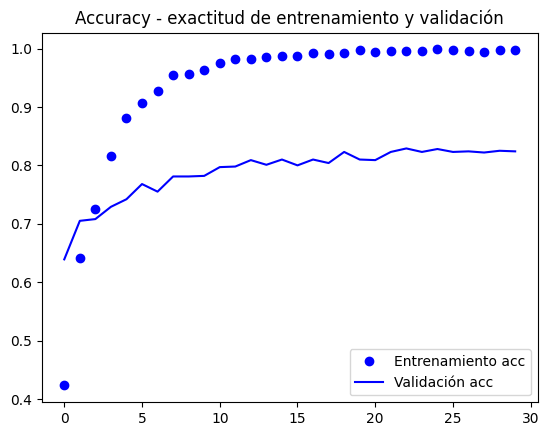

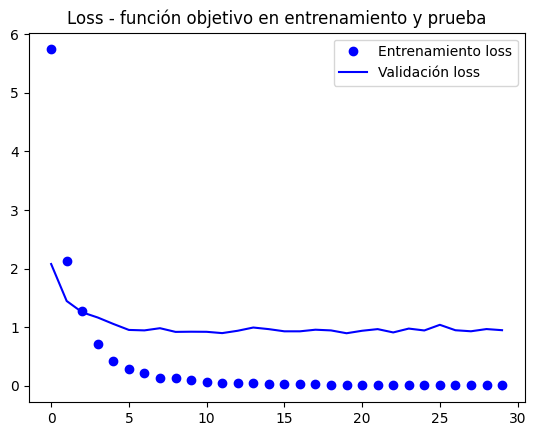

In [22]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()


# Prueba del modelo

In [25]:
test_generator = test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=20,
    shuffle=False
)


test_loss, test_acc = model.evaluate(
    test_features, test_labels,
    batch_size=batch_size,
    verbose=1
)

print('Test accuracy:', test_acc)


50/50 [==============================] - 0s 2ms/step - loss: 0.9490 - acc: 0.8240
Test accuracy: 0.8240000009536743
